In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.nn.functional import mse_loss, l1_loss
from movqgan import get_movqgan_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/miniconda3/envs/lavit/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_images(batch, return_image=False):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    if return_image:
        return Image.fromarray(reshaped.numpy())
    display(Image.fromarray(reshaped.numpy()))


def prepare_image(img):
    """ Transform and normalize PIL Image to tensor. """
    transform = T.Compose([
            T.RandomResizedCrop(512, scale=(1., 1.), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
        ])
    pil_image = transform(img)
    arr = np.array(pil_image.convert("RGB"))
    arr = arr.astype(np.float32) / 127.5 - 1
    return torch.from_numpy(np.transpose(arr, [2, 0, 1]))

In [3]:
device = "mps"
model = get_movqgan_model('67M', pretrained=True, device=device)

img = prepare_image(Image.open("image.jpg")).to(device).unsqueeze(0)

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


In [4]:
with torch.no_grad():
    # quant = embeddings(codebook_indices)
    quant, loss, (perplexity, min_encodings, codebook_indices, sorted_indices) = model.encode(img)
    out = model.decode(quant)

mse = np.round(mse_loss(img, out).item(), 5)
l1 = np.round(l1_loss(img, out).item(), 5)

print("MSE:", mse)
print("L1:", l1)
# show_images(torch.cat((img, out, torch.abs(img - out)), dim=0))

MSE: 0.00427
L1: 0.03868


In [5]:
import watermarking

codes = codebook_indices

### Experiment with distance-based code selection

0.78369140625
00000000000000000000000000000001
[0.5299145579338074]


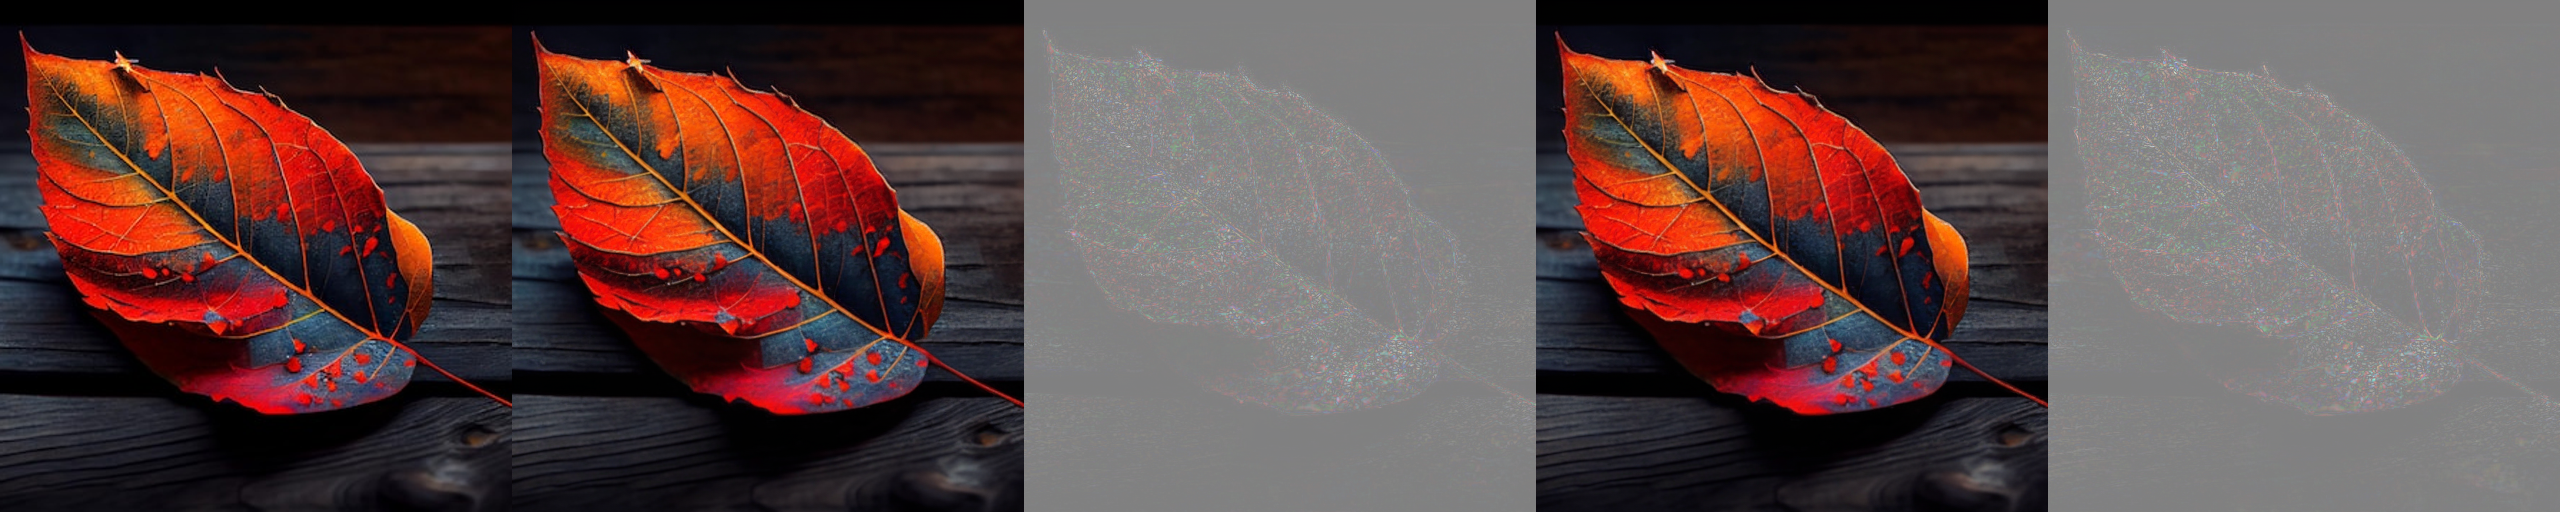

In [6]:
payload = 0b1
n_payload_bits = 1
watermarked_indices = watermarking.redgreen_embed_payload_sorted(codes, sorted_indices=sorted_indices, payload=payload, n_payload_bits=n_payload_bits)

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked_indices.view(1, 64, 64))
    quant, loss, (perplexity, min_encodings, reencoded_indices, reencoded_sorted_indices) = model.encode(watermarked_image)

print((watermarked_indices == reencoded_indices).cpu().numpy().mean())

detection_info = watermarking.detect_payload_sorted(reencoded_indices, reencoded_sorted_indices, n_payload_bits=n_payload_bits)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:032b}")
print(detection_info["average_bits"])

show_images(torch.cat((img, out, torch.abs(img - out), watermarked_image, torch.abs(img - watermarked_image)), dim=0))

In [7]:
# # These are by default 1
# print((sorted_indices[:, 0] == codes).cpu().numpy().mean())
# print((reencoded_sorted_indices[:, 0] == reencoded_indices).cpu().numpy().mean())

print("Code preservation after watermarking", (codes == watermarked_indices).cpu().numpy().mean())                # (1)

print("Code preservation after retokenization", (watermarked_indices == reencoded_indices).cpu().numpy().mean())  # (2)

print("Sorted indices preservation after retokenization", (codes == reencoded_indices).cpu().numpy().mean())      # (3) ~ (1) * (2) = 0.415762

print("Examine more indices", (sorted_indices[:, :10] == reencoded_sorted_indices[:, :10]).cpu().numpy().mean())

Code preservation after watermarking 0.530517578125
Code preservation after retokenization 0.78369140625
Sorted indices preservation after retokenization 0.426513671875
Examine more indices 0.0898681640625
